In [21]:
import os
import torch
import torchvision
from torch.utils.data import  DataLoader
from newdataset import UntrimmedDataset

data_root = os.path.join(os.getcwd(), 'Untrimmed_accline')
n_fft = 32
hop_length = int(n_fft/4)
device = 'cpu'
feature_size = 32

squeeze_net = torchvision.models.squeezenet1_1(progress=True).to(device)
squeeze_net.classifier = torch.nn.Sequential(
    torch.nn.AdaptiveAvgPool2d(output_size=(1,1)),
    torch.nn.Flatten(),
    torch.nn.Linear(512, feature_size, bias=True))
backbone =  squeeze_net

dataset = UntrimmedDataset(root_dir=data_root,
                               kernel_size=1024,
                               stride=256,
                               device='cpu',
                               n_fft=n_fft,
                               hop_length=hop_length)
    
dataloader = DataLoader(dataset, batch_size=4)

/Users/lilmae/Desktop/CarVibration/newdataset.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_stft = torch.stft(input=torch.tensor(x_data),n_fft=self.n_fft,hop_length=self.hop_length,return_complex=True)
/Users/lilmae/Desktop/CarVibration/newdataset.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_stft = torch.stft(input=torch.tensor(y_data),n_fft=self.n_fft,hop_length=self.hop_length,return_complex=True)
/Users/lilmae/Desktop/CarVibration/newdataset.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_stft = torch.stft(inp

77
torch.Size([3, 17, 129])


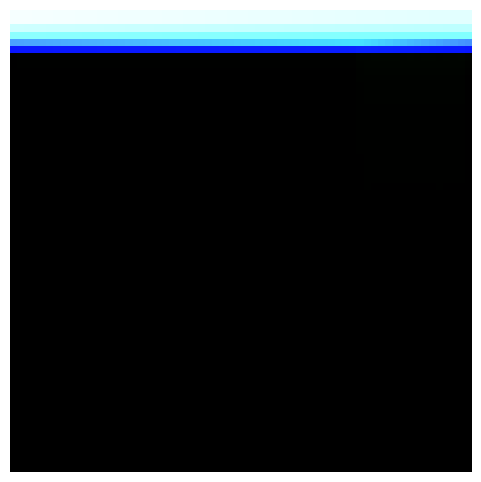

In [22]:
import matplotlib.pyplot as plt
print(len(dataset))

for stft, class_info, is_new in dataloader:
    a_stft = stft[2]
    # print(a_stft)
    break
print(a_stft.shape)

new_stft = []
for ch in a_stft:
    new_stft.append(torch.abs(ch))
new_stft = torch.stack(new_stft)



from torchvision import transforms, utils
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # 이미지 크기를 256x256으로 조정
])

new_stft = transform(new_stft)

tensor_rgb = new_stft.permute(1, 2, 0)

plt.figure(figsize=(6, 6))
plt.imshow(tensor_rgb)
plt.axis('off')
plt.show()

In [23]:
from torchvision import transforms, utils

transform = transforms.Compose([
    transforms.Resize((64, 64)),  # 이미지 크기를 256x256으로 조정
    transforms.RandomHorizontalFlip(),  # 50% 확률로 수평 반전
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
])

for stft, class_info, is_new in dataloader:
    stft = transform(stft)
    res = squeeze_net(stft)
    a_res = res[0]
    print(a_res.shape)
    break

/Users/lilmae/Desktop/CarVibration/newdataset.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_stft = torch.stft(input=torch.tensor(x_data),n_fft=self.n_fft,hop_length=self.hop_length,return_complex=True)
/Users/lilmae/Desktop/CarVibration/newdataset.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_stft = torch.stft(input=torch.tensor(y_data),n_fft=self.n_fft,hop_length=self.hop_length,return_complex=True)
/Users/lilmae/Desktop/CarVibration/newdataset.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_stft = torch.stft(inp

TypeError: Input tensor should be a float tensor. Got torch.complex128.

In [ ]:
import torch.nn.functional as F


batch = torch.randn([10, 32])

norm_batch = F.normalize(batch, p=2,dim=1)
sim_matrix = torch.mm(norm_batch, norm_batch.t())

pos = []
neg = []
for i in range(batch.shape[0]):
    for j in range(batch.shape[0]):
        if j==i+1:
            pos.append(sim_matrix[i][j])
        elif j>i:
            neg.append(sim_matrix[i][j])
pos = torch.stack(pos)
neg = torch.stack(neg)
print(f'pos_sum : {pos}')
print(f'neg_sum : {neg}')

In [ ]:
def nce_loss_fn(history, future, similarity, temperature='0.1'):
    criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')

    N = history.shape[0]
    
    
    sim = similarity(history, future)
    
    
    pos_sim = K.exp(tf.linalg.tensor_diag_part(sim)/temperature)

    tri_mask = np.ones(N ** 2, dtype=np.bool).reshape(N, N)
    tri_mask[np.diag_indices(N)] = False
    neg = tf.reshape(tf.boolean_mask(sim, tri_mask), [N, N - 1])
    all_sim = K.exp(sim/temperature)

    logits = tf.divide(K.sum(pos_sim), K.sum(all_sim, axis=1))

    lbl = np.ones(history.shape[0])
    # categorical cross entropy
    loss = criterion(y_pred = logits, y_true = lbl)
    # loss = K.sum(logits)
    # divide by the size of batch
    #loss = loss / lbl.shape[0]
    # similarity of positive pairs (only for debug)
    mean_sim = K.mean(tf.linalg.tensor_diag_part(sim))
    mean_neg = K.mean(neg)
    return loss, mean_sim, mean_neg

In [ ]:
import torch
import torch.nn.functional as F

# 임의의 10개 텐서 생성 (예시로 각각 128 차원)
tensors = [torch.randn(128) for _ in range(10)]

# 모든 텐서를 하나의 배치로 쌓기
tensor_stack = torch.stack(tensors)

# L2 정규화 (코사인 유사도를 위해 필요)
tensor_norm = F.normalize(tensor_stack, p=2, dim=1)

# 코사인 유사도 계산
cosine_similarities = torch.mm(tensor_norm, tensor_norm.t())

# 유사도 행렬 출력
print(cosine_similarities)